In [32]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.animation as ani
import matplotlib.cm as cm 

# allows animation features within notebook
%matplotlib notebook

In [2]:
# constants of nature

mu0 = 4 * np.pi * 1e-7
e0 = 8.85e-12
c = np.sqrt(1 / (mu0 * e0))
k = 1 / (4 * np.pi * e0)

# Use an artificial speed of light in order to visualize how it changes electric field evolution
c = 0.5
dt = 0.0007

In [3]:
# create timesteps array with a given dt small enough to calculate
# both dipole trajectory and electric field evolution accurately
t0 = 0
t1 = 40
timesteps = np.arange(t0, t1, dt)

In [4]:
# class to store particle data in order to create dipole trajectory
class Particle:
    
    def __init__(self, mass=1, charge=1, pos=np.array([0.0,0.0,0.0]), vel=np.array([0.0,0.0,0.0]), acc=np.array([0.0,0.0,0.0])):
        self.mass = mass
        self.charge = charge
        self.pos = pos
        self.vel = vel
        self.acc = acc

# class that holds all information about a particular dipole, including trajectory given a certain external force
class Dipole:
    
    def __init__(self, timesteps, distance=1, charge=1, mass=1, k=1, external_force_arr=np.zeros(timesteps.size)):
        self.distance = distance
        self.charge = charge
        self.mass = mass
        self.particle1 = Particle(mass=self.mass, charge=self.charge, pos=np.array([-distance/2, 0,0]))
        self.particle2 = Particle(mass=self.mass, charge=-self.charge, pos=np.array([distance/2, 0,0]))
        self.initial_position_1 = np.array([-distance/2, 0,0])
        self.initial_position_2 = np.array([distance/2, 0,0])
        self.dipole_moment = self.charge * np.array([self.distance, 0, 0])
        self.force = 0
        self.timesteps = timesteps
        self.pos1 = np.zeros((self.timesteps.size, 3))
        self.pos2 = np.zeros((self.timesteps.size, 3))
        
        self.external_force_arr = external_force_arr
        
        self.vel_1 = np.zeros((self.timesteps.size, 3))
        self.accel_1 = np.zeros((self.timesteps.size, 3))
        
        self.vel_2 = np.zeros((self.timesteps.size, 3))
        self.accel_2 = np.zeros((self.timesteps.size, 3))
        
        self.k = k      
        
    def update(self, external_force):
        r = self.particle2.pos - self.particle1.pos
        
        spring_force = self.k * (np.linalg.norm(r) - self.distance) * (r / np.linalg.norm(r))
        force = spring_force + external_force * self.charge
        
        self.particle1.acc = force / self.particle1.mass
        self.particle2.acc = -force / self.particle2.mass
        self.particle1.vel = self.particle1.vel + self.particle1.acc * dt
        self.particle2.vel = self.particle2.vel + self.particle2.acc * dt
        
        self.particle1.pos += self.particle1.vel * dt
        self.particle2.pos += self.particle2.vel * dt
        
    def calc_trajectory(self):
        
        for i, time in enumerate(self.timesteps):
            self.pos1[i] = self.particle1.pos
            self.pos2[i] = self.particle2.pos
            
            self.vel_1[i] = self.particle1.vel
            self.vel_2[i] = self.particle2.vel

            self.accel_1[i] = self.particle1.acc
            self.accel_2[i] = self.particle2.acc
            
            external_force = np.array([self.external_force_arr[i], 0, 0])
            
            self.update(external_force)
            
        return self.pos1, self.pos2    

In [39]:
def sinusoidal_force(E0,omega,timesteps, phase=0):
    return (E0 * np.sin(omega * timesteps + phase))

<IPython.core.display.Javascript object>


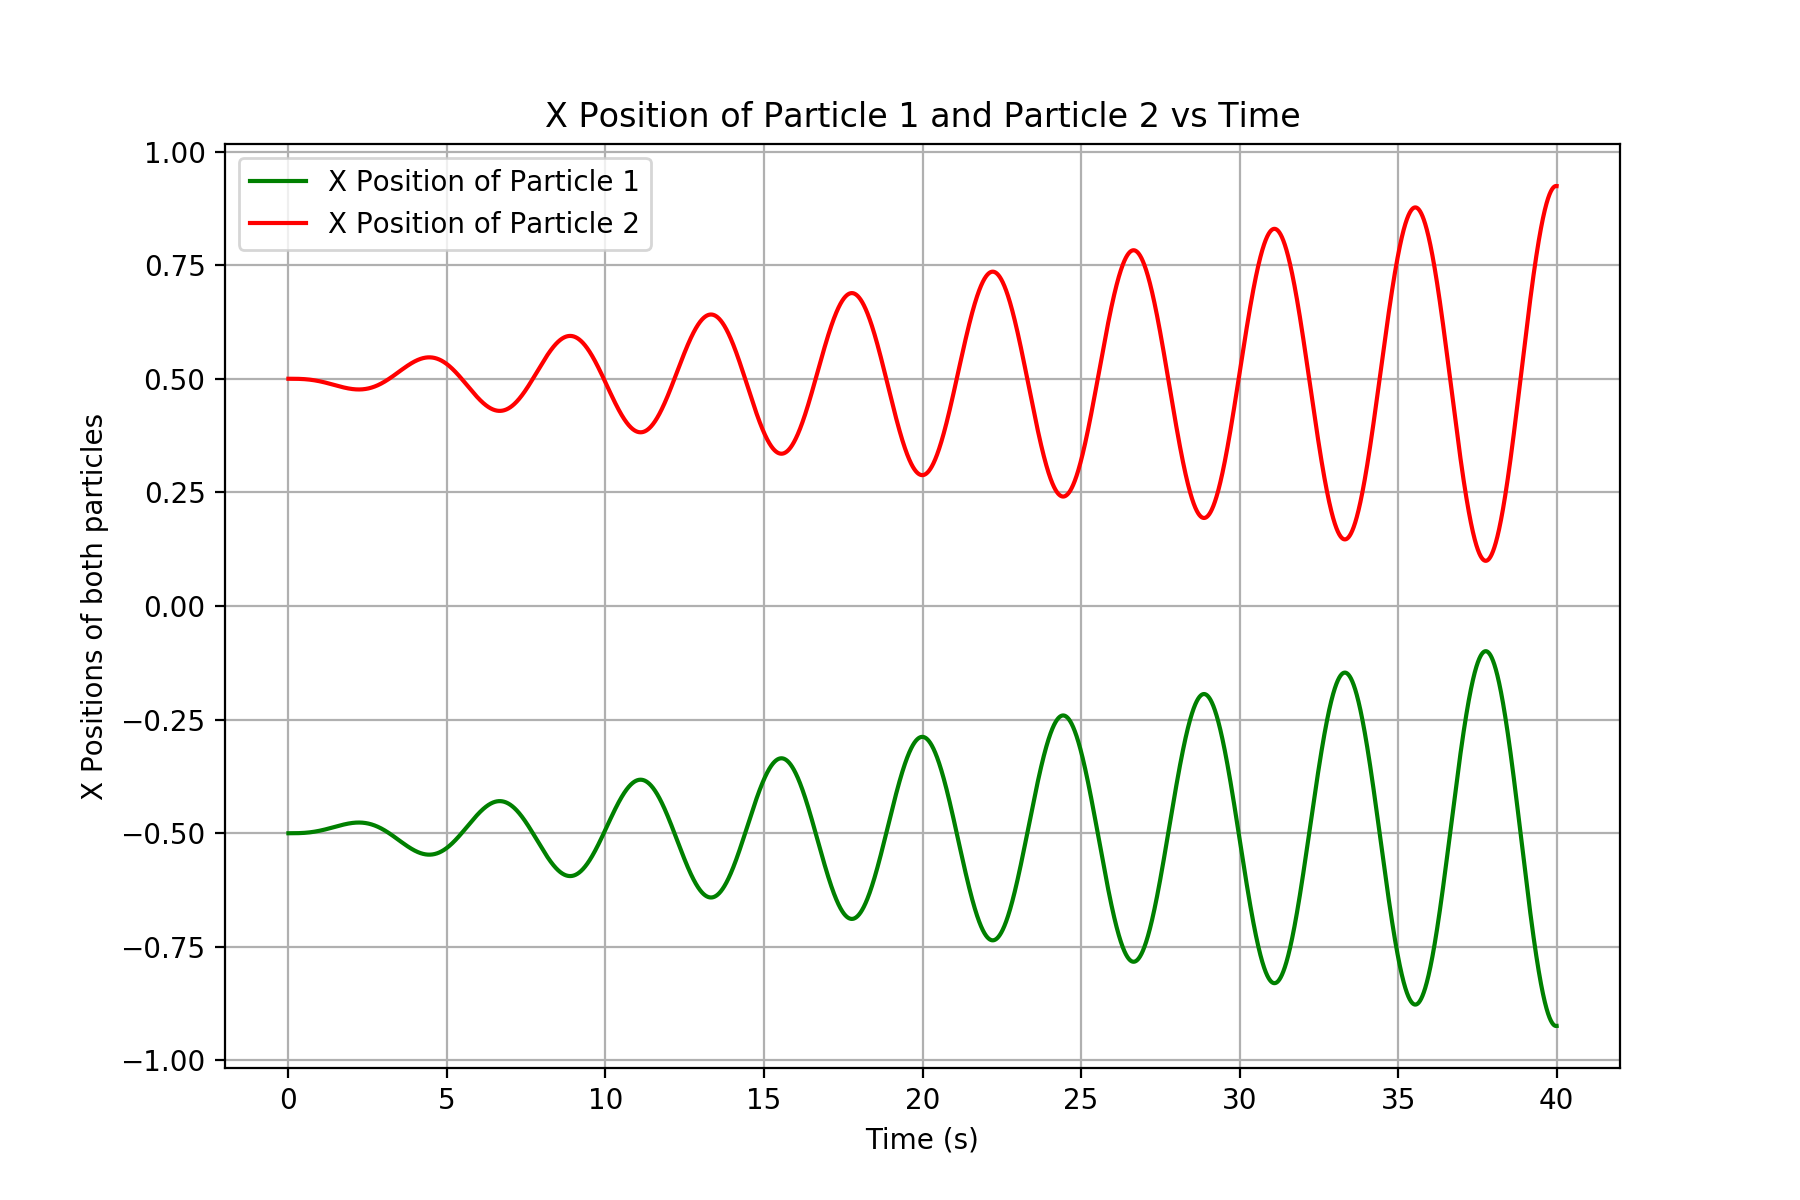

In [40]:
E0 = 0.03 # magnitude of electric field applied to dipole
omega = np.sqrt(2) # theoretically calculated resonant frequency

# external driven sinusoidal force
sinusoidal_force_array = sinusoidal_force(E0,omega,timesteps)

# create dipole and calculate trajectory
dipole = Dipole(timesteps, external_force_arr=sinusoidal_force_array)
dipole.calc_trajectory()

fig, (ax1) = plt.subplots(1, figsize=(9,6))

ax1.plot(timesteps, dipole.pos1[:, 0], 'g', label = 'X Position of Particle 1')
ax1.plot(timesteps, dipole.pos2[:, 0], 'r', label = 'X Position of Particle 2')
ax1.grid()


ax1.set_xlabel("Time (s)")
ax1.set_ylabel("X Positions of both particles")
ax1.title.set_text("X Position of Particle 1 and Particle 2 vs Time")
ax1.legend()
plt.show()

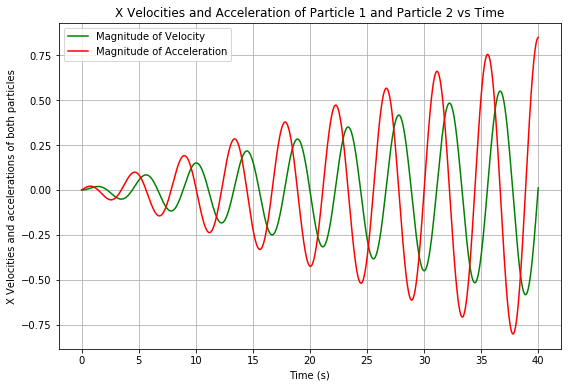

In [7]:
fig, (ax1) = plt.subplots(1, figsize=(9,6))

ax1.plot(timesteps, dipole.vel_1[:, 0], 'g', label = 'Magnitude of Velocity')
ax1.plot(timesteps, dipole.accel_1[:, 0], 'r', label = 'Magnitude of Acceleration')
ax1.grid()


ax1.set_xlabel("Time (s)")
ax1.set_ylabel("X Velocities and accelerations of both particles")
ax1.title.set_text("X Velocities and Acceleration of Particle 1 and Particle 2 vs Time")
ax1.legend()

plt.show()

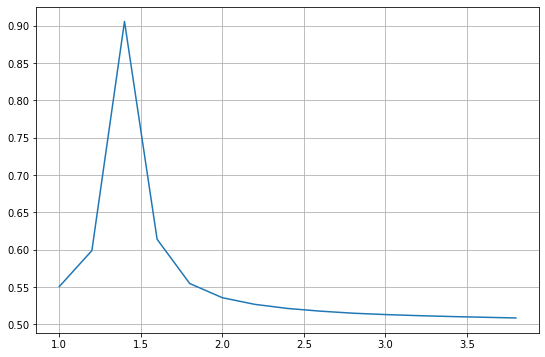

In [8]:
# create range of frequencies for which to calculate trajectories
omega_arr = np.arange(1,4,0.2)

# create array to store amplitude of oscillation for each frequency
oscillation_amplitudes = np.zeros(np.shape(omega_arr))

for i, omega in enumerate(omega_arr):
    # create dipole with external force with given frequency
    external_force_arr = sinusoidal_force(E0,omega,timesteps)
    current_dipole = Dipole(timesteps, external_force_arr=external_force_arr)
    posA,posB = current_dipole.calc_trajectory()    
    
    # determine maximum amplitude for trajectory and store in array
    oscillation_amplitudes[i] = np.amax(posB)
    
fig, (ax1) = plt.subplots(1, figsize=(9,6))

ax1.plot(omega_arr,oscillation_amplitudes)
ax1.grid()

In [9]:
def calc_electric_field(dipole, point):
    ''' function to calculate electric field for a point from initial position of the dipole'''
    
    dif1 = point - dipole.initial_position_1
    dif2 = point - dipole.initial_position_2
    
    r_mag1 = np.linalg.norm(dif1)
    r_mag2 = np.linalg.norm(dif2)
    
    Ex = dipole.charge * (dif1[0]*r_mag1**-3 - dif2[0]*r_mag2**-3)
    Ey = dipole.charge * (dif1[1]*r_mag1**-3 - dif2[1]*r_mag2**-3)
    Ez = dipole.charge * (dif1[2]*r_mag1**-3 - dif2[2]*r_mag2**-3)
    
    return np.array([Ex, Ey, Ez])

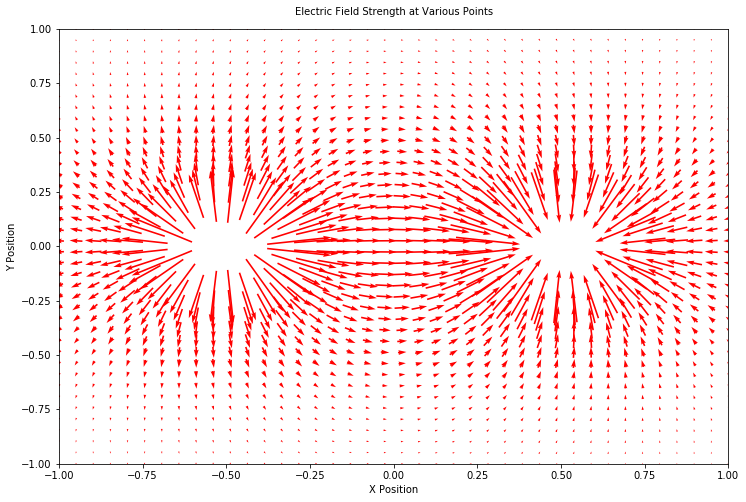

In [22]:
# This cell is to plot electric field around dipole at initial conditions
fig = plt.figure(figsize=(12,8))
ax = plt.axes(xlim=(-1, 1), ylim=(-1, 1))

# create meshgrid of points
Nsteps = 40
grid_min = -1
grid_max = 1

x, y = np.meshgrid(np.linspace(grid_min, grid_max, Nsteps),
                      np.linspace(grid_min, grid_max, Nsteps))
E = calc_electric_field(dipole, [x, y, 0])

# find maximum magnitude for mask
magEfield = np.sqrt(E[0]**2 + E[1]**2 + E[2]**2)
maxMagEfield = np.max(magEfield)

mask_efield = np.where(magEfield < maxMagEfield * 0.02)

ttl = ax.text(.5, 1.05, '', transform = ax.transAxes, va='top', ha = 'center')
ttl.set_text("Electric Field Strength at Various Points")
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")

Qplot = ax.quiver(x[mask_efield], y[mask_efield], 
                   E[0][mask_efield], E[1][mask_efield], 
                   units='inches',pivot='mid',color='r', scale=25)

In [23]:
# binary search algorithm used for electric field calculation. Time complexity O(log(n)).
def binary_search(array, value):
    '''binary search algorithm for value in an array'''
    low = 0
    high = array.size - 1
    midpoint = int((high - low) / 2)
    n = 0
    
    if value > array[high]:
        return -1
    
    while(low <= high and n < array.size):
        n+=1
        midpoint = int((low + high) / 2)
        if array[midpoint] == value:
            return midpoint
        elif array[midpoint] > value:
            high = midpoint - 1
        elif array[midpoint] < value:
            low = midpoint + 1
    return midpoint


In [24]:
def relax(arr, relax_mask):
    '''relaxation method used to fill in gaps in arrays'''
    keep_same = arr[relax_mask]
    first = arr[0]
    last = arr[-1]    
    
    arr = (np.roll(arr,-1, axis=0) + np.roll(arr,1,axis=0))/2
    
    arr[relax_mask] = keep_same
    arr[0] = first
    arr[-1] = last
    return arr

In [25]:
# class to store electric field evolution of a single point in space over time
class point_in_space():
    
    def __init__(self, x, y, z, timesteps, relax_iterations=1000):
        self.xyz = np.array([x, y, z]) # position of point in space
        self.electric_field = np.zeros((timesteps.size, 3)) # combined electric fields
        self.electric_field_1 = np.zeros((timesteps.size, 3)) # electric field contribution from particle 1
        self.electric_field_2 = np.zeros((timesteps.size, 3)) # electric field contribution from particle 2
        self.first_index = 0 # first index that electric field from both particles reaches point in space
        self.first_index1 = 0 # first index that electric field from particle 1 reaches point in space
        self.first_index2 = 0 # first index that electric field from particle 2 reaches point in space
        self.iteration_flag = False
        self.relax_iterations = relax_iterations # iterations for relaxation method
        self.timesteps = timesteps
        
        self.indices = np.zeros(timesteps.shape)
        
    def reset_electric_field(self):
        self.electric_field_1 = np.zeros((timesteps.size, 3))
        self.electric_field_2 = np.zeros((timesteps.size, 3))
        self.electric_field = np.zeros((timesteps.size, 3))
        
    def populate_electric_field_array(self, pos1, pos2, time, i):
        '''function to populate electric field array at a certain point in time'''
        r1 = self.xyz - pos1 # distance from particle 1
        r2 = self.xyz - pos2 # distance from particle 2

        time1 = time + np.linalg.norm(r1) / c # time when particle 1 information will actually reach point in space
        time2 = time + np.linalg.norm(r2) / c # time when particle 2 information will actually reach point in space

        # indices of time to reach point in space
        index1 = binary_search(self.timesteps, time1) 
        index2 = binary_search(self.timesteps, time2)

        self.indices[i] = index1

        # calculation of the elctric field at this point in time
        r_mag1 = np.linalg.norm(r1)
        r_mag2 = np.linalg.norm(r2)

        Ex1 = dipole.charge * (r1[0]*r_mag1**-3)
        Ey1 = dipole.charge * (r1[1]*r_mag1**-3)
        Ez1 = dipole.charge * (r1[2]*r_mag1**-3)

        Ex2 = -dipole.charge * (r2[0]*r_mag2**-3)
        Ey2 = -dipole.charge * (r2[1]*r_mag2**-3)
        Ez2 = -dipole.charge * (r2[2]*r_mag2**-3)

        # end calculation if we have reached the end of our timesteps array
        if index1 != -1:
            self.electric_field_1[index1] = np.array([Ex1, Ey1, Ez1])
        if index2 != -1:
            self.electric_field_2[index2] = np.array([Ex2, Ey2, Ez2])

        if index1 == -1 and index2 == -1:
            self.iteration_flag = True

        # store first indices when dipole movement will reach point in space
        if(i == 0):
            self.first_index1 = index1
            self.first_index2 = index2
            self.electric_field_1[:index1] = np.array([Ex1, Ey1, Ez1])
            self.electric_field_2[:index2] = np.array([Ex2, Ey2, Ez2])
            
    def calculate_electric_field(self, dipole):
        '''function to completely calculate electric field evolution over time'''
        self.iteration_flag = False
        self.reset_electric_field()
        pos1 = dipole.pos1
        pos2 = dipole.pos2
        for i, t in enumerate(self.timesteps):
            # populate arrays for certain point in time
            self.populate_electric_field_array(pos1[i], pos2[i], t, i)
            if self.iteration_flag:
                break # end computation if reached end of timesteps array
        
        self.first_index = np.max(self.first_index1 + self.first_index2)
        
        # fill in gaps in array because not all values in timesteps will be filled at this point
        self.relax_electric_fields()
        
        # add contributions of electric field from both particles
        self.electric_field = self.electric_field_1 + self.electric_field_2
        
    def relax_electric_fields(self):
        '''iterative relaxation method used in order to fill gaps in electric field array'''
        
        # want to leave already calculated points the same
        relax_mask_1 = np.where(np.abs(self.electric_field_1) != 0)
        relax_mask_2 = np.where(np.abs(self.electric_field_2) != 0)

        for i in range(self.relax_iterations): # fill in gaps between calculated points for both arrays
            self.electric_field_1 = relax(self.electric_field_1, relax_mask_1)
            self.electric_field_2 = relax(self.electric_field_2, relax_mask_2)

In [26]:
# example point in space
p1 = point_in_space(-0.750, 0.5, 0, timesteps)
p1.calculate_electric_field(dipole)

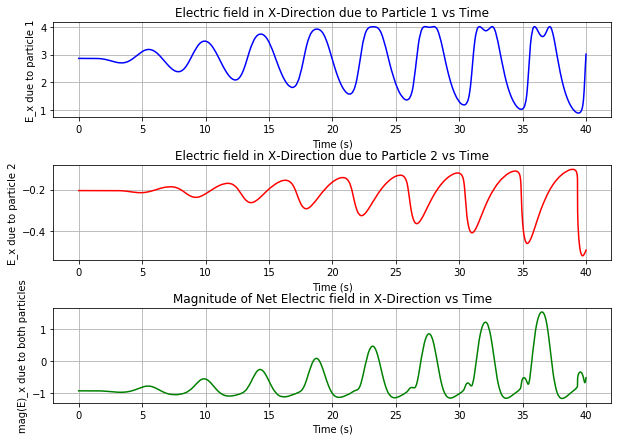

In [27]:
# This cell is for plotting different components of the calculated electric field for p1

fig, (ax1,ax2,ax3) = plt.subplots(3, figsize=(10,7))
ax1.plot(timesteps[:], p1.electric_field_1[:, 1], 'b-')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("E_x due to particle 1")

ax2.plot(timesteps[:], p1.electric_field_2[:, 1], 'r-')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("E_x due to particle 2")


ax3.plot(timesteps, p1.electric_field[:, 0], 'g-')
ax3.set_xlabel("Time (s)")
ax3.set_ylabel("mag(E)_x due to both particles")

ax1.grid()
ax2.grid()
ax3.grid()

ax1.title.set_text("Electric field in X-Direction due to Particle 1 vs Time")
ax2.title.set_text("Electric field in X-Direction due to Particle 2 vs Time")
ax3.title.set_text("Magnitude of Net Electric field in X-Direction vs Time")

fig.subplots_adjust(hspace=.5)

In [28]:
def calculate_vector_evolution_array(x, y, dipole):
    ''' function that calculates vector evolution for a meshgrid of points '''
    vector_evolution = np.empty(x.size, dtype=point_in_space) # create array of points
    num_points = x.size
    for i in range(num_points):
        point = point_in_space(x[i], y[i], 0, timesteps)
        point.calculate_electric_field(dipole)
        vector_evolution[i] = point # populate array
        
        # log calculation number becuase these calculations can take a very long time
        print("calculated electric field evolution ", (i + 1), "out of ", num_points)
    
    return vector_evolution

In [29]:
def get_2D_electric_field(p_array, unit_vectors=True):
    '''function to calculate vectors for plotting from array of points'''
    x = np.zeros(p_array.size)
    y = np.zeros(p_array.size)
    Ex = np.zeros((p_array.size, timesteps.size))
    Ey = np.zeros((p_array.size, timesteps.size))
    for i, point in enumerate(p_array):
        x[i] = point.xyz[0]
        y[i] = point.xyz[1]
        Ex_current = point.electric_field[:, 0]
        Ey_current = point.electric_field[:, 1]
        
        if unit_vectors: # calculate unit vectors
            mag_vec = np.sqrt(Ex_current**2 + Ey_current**2) # magnitude of individual vectors
            Ex[i] = Ex_current / mag_vec # divide by magnitude
            Ey[i] = Ey_current / mag_vec   
        else:
            Ex[i] = Ex_current
            Ey[i] = Ey_current
        
    return x, y, Ex, Ey


In [30]:
# create a meshgrid of points around dipole in which to calculate electric field evolution
Nsteps = 4
grid_min = -1
grid_max = 1

x_grid, y_grid = np.meshgrid(np.linspace(grid_min, grid_max, Nsteps),
                      np.linspace(grid_min, grid_max, Nsteps))

x_test = np.ravel(x_grid)
y_test = np.ravel(y_grid)

# store array of calculated points
p_array_meshgrid = calculate_vector_evolution_array(x_test, y_test, dipole)

calculated electric field evolution  1 out of  16
calculated electric field evolution  2 out of  16
calculated electric field evolution  3 out of  16
calculated electric field evolution  4 out of  16
calculated electric field evolution  5 out of  16
calculated electric field evolution  6 out of  16
calculated electric field evolution  7 out of  16
calculated electric field evolution  8 out of  16
calculated electric field evolution  9 out of  16
calculated electric field evolution  10 out of  16
calculated electric field evolution  11 out of  16
calculated electric field evolution  12 out of  16
calculated electric field evolution  13 out of  16
calculated electric field evolution  14 out of  16
calculated electric field evolution  15 out of  16
calculated electric field evolution  16 out of  16


<IPython.core.display.Javascript object>


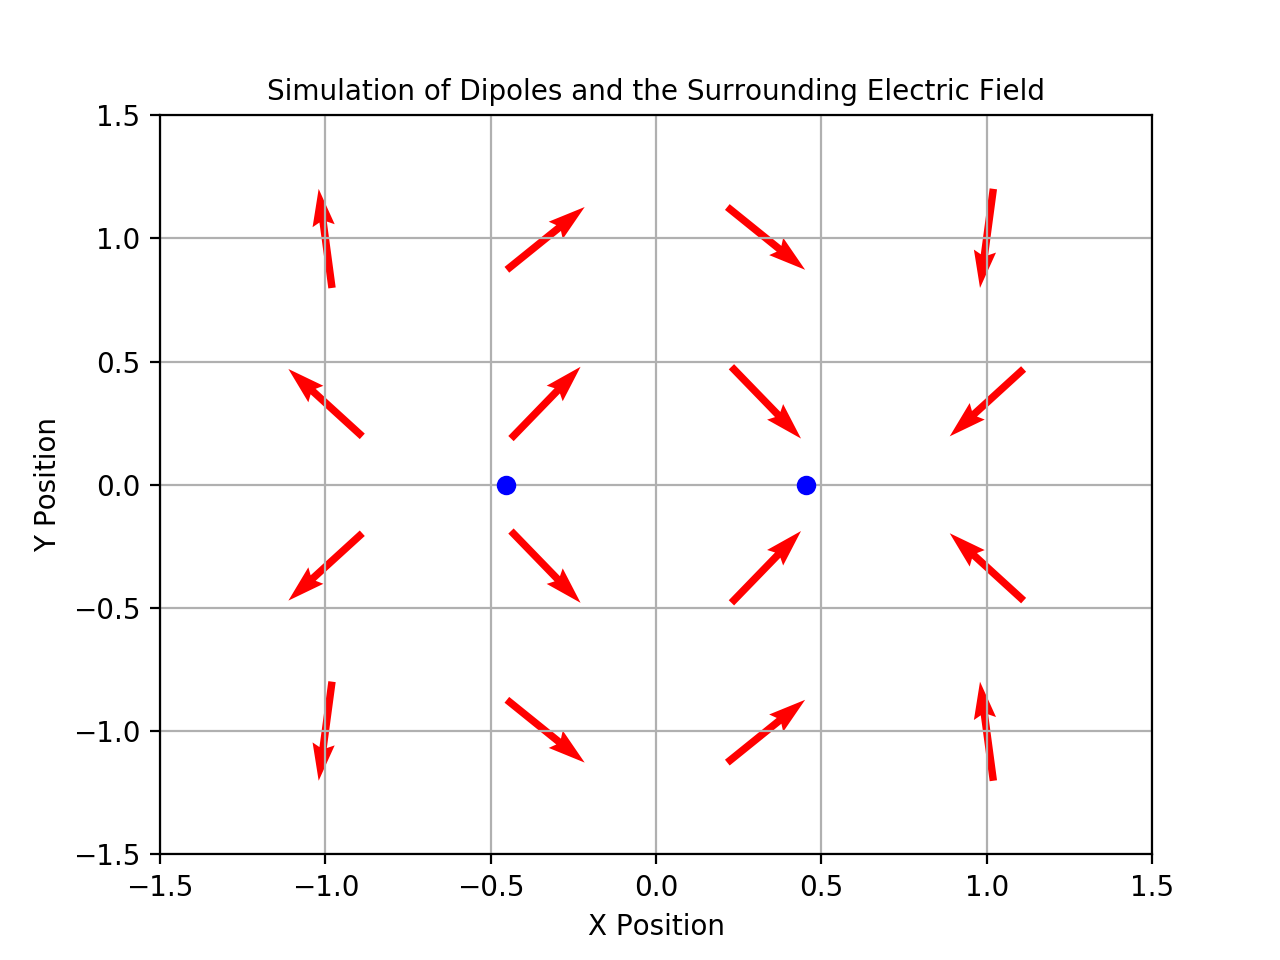

In [33]:
fig = plt.figure()
ax = plt.axes(xlim=(-1.5, 1.5), ylim=(-1.5, 1.5))
initial_index = 0 # index to start the simulation at
speed_factor = 10 # speed of simulation
scale_factor = 1 # scale to change size of vectors
frame_num = int(timesteps.size / speed_factor) # number of frames before simulation repeats

p_array = p_array_meshgrid # use meshgrid from before, although can be any array of points
x, y, Ex, Ey = get_2D_electric_field(p_array, unit_vectors=True) # calculate vectors for plotting
    
plt.grid()

# plot initial conditions
E_changing_plot = ax.quiver(x, y, 
                   Ex[:, 0], Ey[:, 0], 
                   units='inches',pivot='mid',color='r', scale=2)

pos1 = dipole.pos1
pos2 = dipole.pos2

# plot initial positions for dipole trajectory
dipole_plot, = ax.plot([pos1[0][0], pos2[0][0]], [pos1[0][1], pos2[0][1]], 'bo')

ttl = ax.text(.5, 1.05, '', transform = ax.transAxes, va='top', ha = 'center')
    
def plot_point_in_space(i):
    
    # calculate x and y vector components for each point in space
    x_component = Ex[:, i * speed_factor] * scale_factor
    y_component = Ey[:, i * speed_factor] * scale_factor
    
    # update electric field plot
    E_changing_plot.set_UVC(x_component, y_component)
    
    dipole_x = [pos1[i * speed_factor, 0], pos2[i * speed_factor, 0]]
    
    dipole_plot.set_xdata(dipole_x) # dipole only oscillates in x-direction
    
    ttl.set_text("Simulation of Dipoles and the Surrounding Electric Field")
    ax.set_xlabel("X Position")
    ax.set_ylabel("Y Position")
    
    return dipole_plot, E_changing_plot

# animation object
anim = ani.FuncAnimation(fig, plot_point_in_space,
                               frames=frame_num, interval=1, blit=False)
plt.show()

In [36]:
E0_piecewise = 0.02

def piecewise_force(timesteps,E0):
    force = np.zeros(np.shape(timesteps))
    for i in range(np.size(timesteps)):
        if i < np.size(timesteps)/4:
            force[i] = E0
        else:
            force[i] = 0
    return force
 


piecewise_force = piecewise_force(timesteps,E0_piecewise)
dipole_piecewise = Dipole(timesteps = timesteps, distance =1,k = 0, external_force_arr=piecewise_force)
posa,posb = dipole_piecewise.calc_trajectory()

new_point = point_in_space(0.5, 5, 0, timesteps)
new_point.calculate_electric_field(dipole_piecewise)

<IPython.core.display.Javascript object>


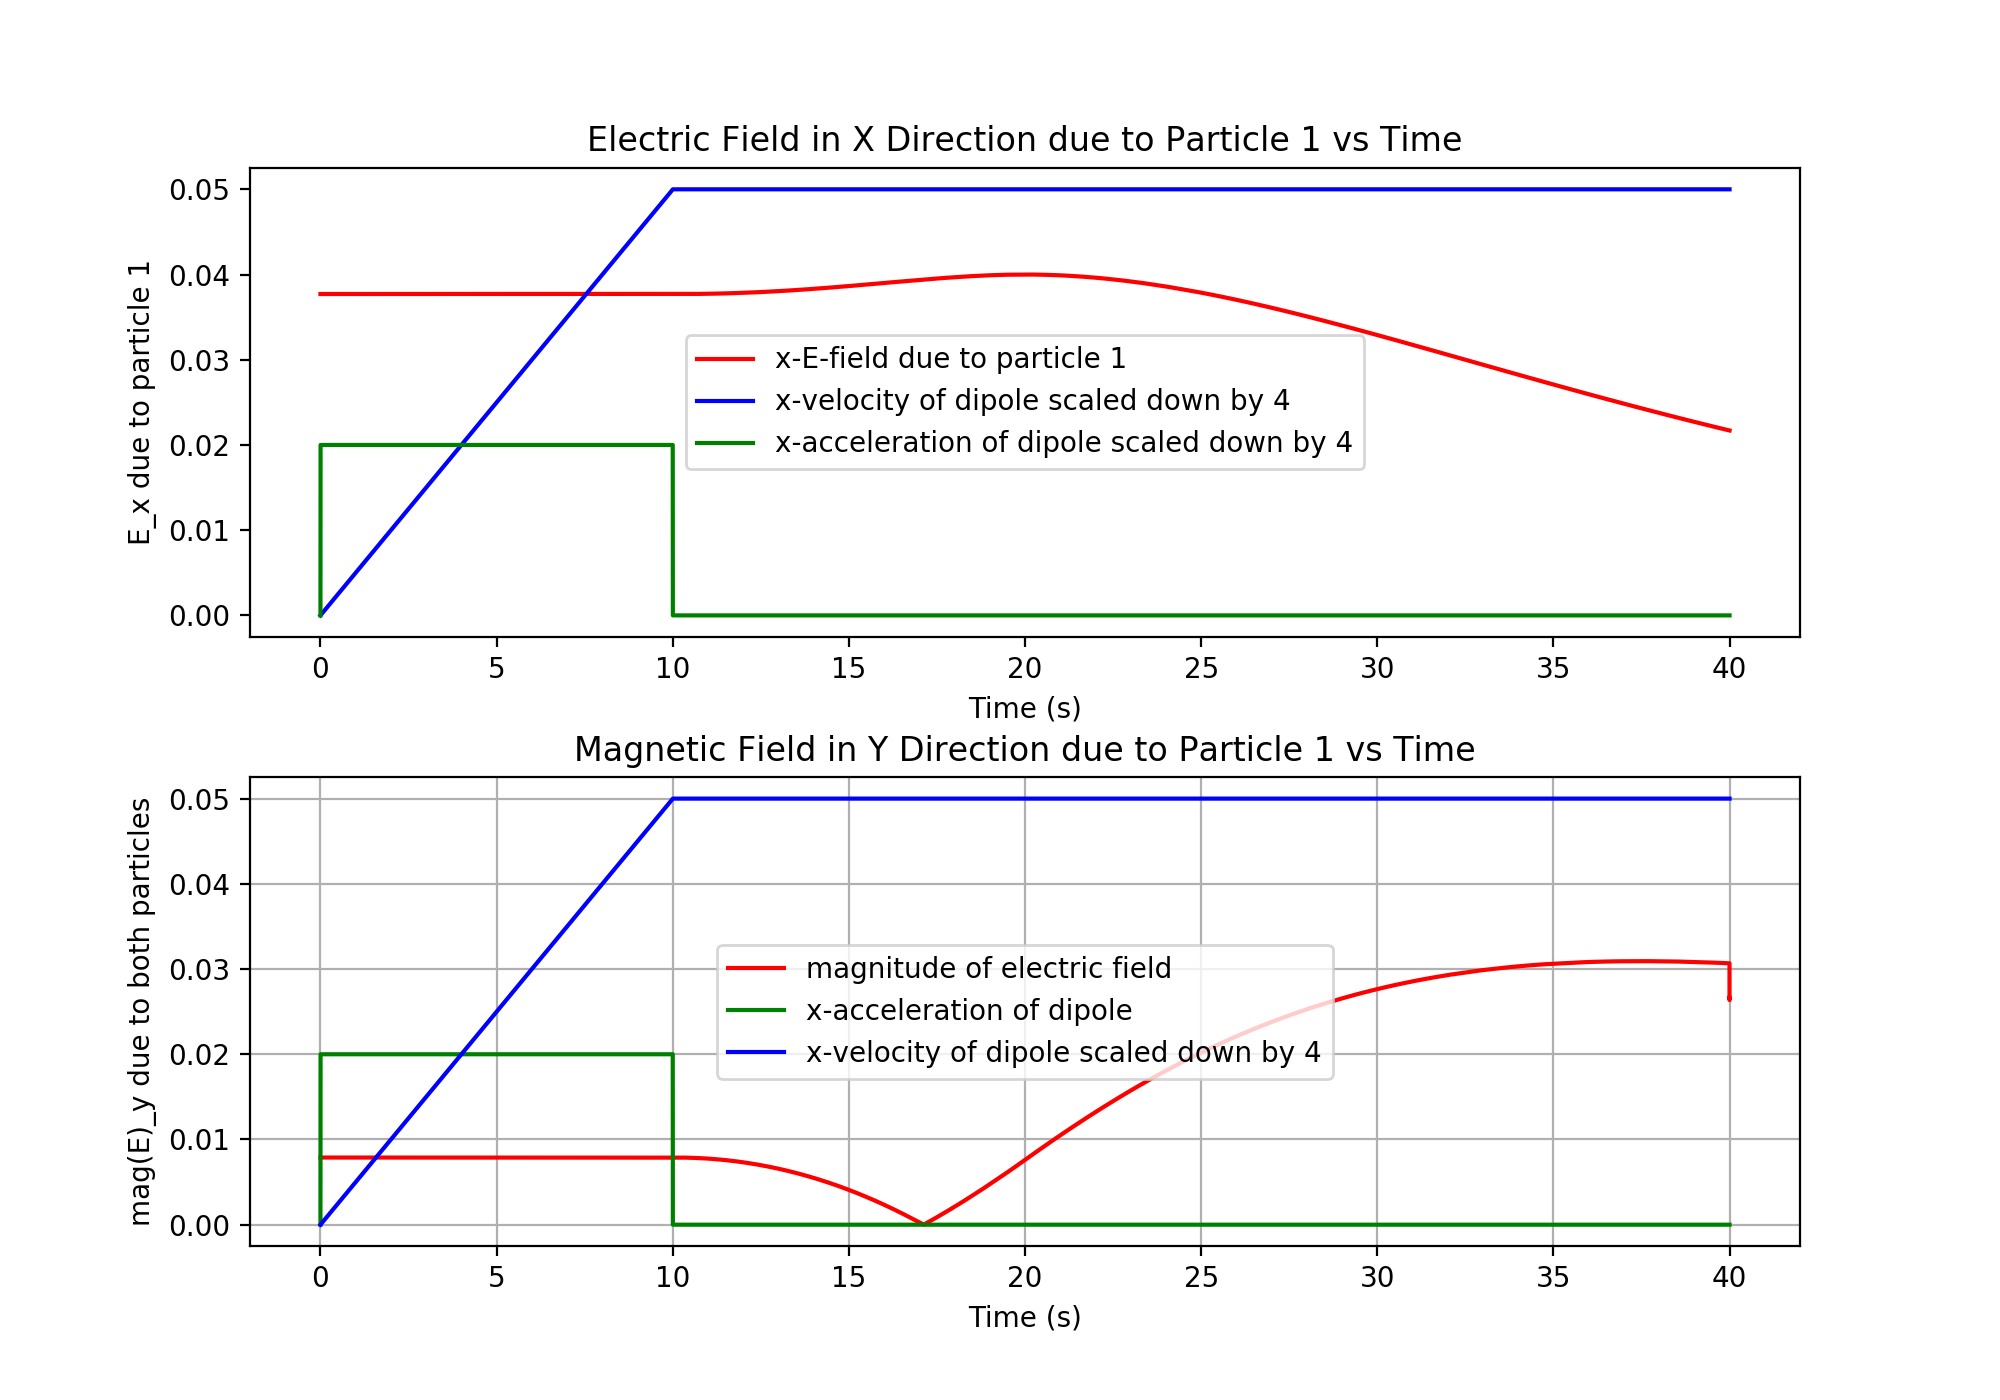

In [38]:
def magnitude(a1,a2):
    return np.sqrt(a1**2 + a2**2)


fig, (ax1,ax3) = plt.subplots(2, figsize=(10,7))
ax1.plot(timesteps, new_point.electric_field_1[:, 1], 'r-', label = 'x-E-field due to particle 1')
ax1.plot(timesteps, dipole_piecewise.vel_1[:, 0]/4, 'b-', label = 'x-velocity of dipole scaled down by 4')
ax1.plot(timesteps, dipole_piecewise.accel_1[:, 0], 'g-', label = 'x-acceleration of dipole scaled down by 4')
ax1.grid()
ax1.legend()


ax1.set_xlabel("Time (s)")
ax1.set_ylabel("E_x due to particle 1")
ax1.legend()


ax3.plot(timesteps, magnitude(new_point.electric_field[:, 1],new_point.electric_field[:, 0]), 'r-', label = 'magnitude of electric field')
ax3.plot(timesteps, dipole_piecewise.accel_1[:, 0], 'g-', label = 'x-acceleration of dipole')
ax3.plot(timesteps, dipole_piecewise.vel_1[:, 0]/4, 'b-', label = 'x-velocity of dipole scaled down by 4')
ax3.legend()


ax3.set_xlabel("Time (s)")
ax3.set_ylabel("mag(E)_y due to both particles")

ax1.grid()
#ax2.grid()
ax3.grid()

ax1.title.set_text("Electric Field in X Direction due to Particle 1 vs Time")
ax3.title.set_text("Magnetic Field in Y Direction due to Particle 1 vs Time")

fig.subplots_adjust(hspace=.3)

In [44]:
# superposition
omega_1 = np.sqrt(3)
omega_2 = 2
E0_a = 0.02
E0_b = 0.03
phase_shift = np.pi/3


# superPos_force = sinusoidal_force(E0_a, omega_1, timesteps) + sinusoidal_force(E0_b, omega_2, timesteps, phase=phase_shift)
superPos_force = E0_a * np.sin(omega_1 * timesteps) + E0_b * np.sin(omega_2 * timesteps + phase_shift)

dipole_superPos = Dipole(timesteps = timesteps, distance =1,k = 1, external_force_arr=superPos_force)
dipole_superPos.calc_trajectory()

superPos_point = point_in_space(0.5, 3, 0, timesteps)
superPos_point.calculate_electric_field(dipole_superPos)

<IPython.core.display.Javascript object>


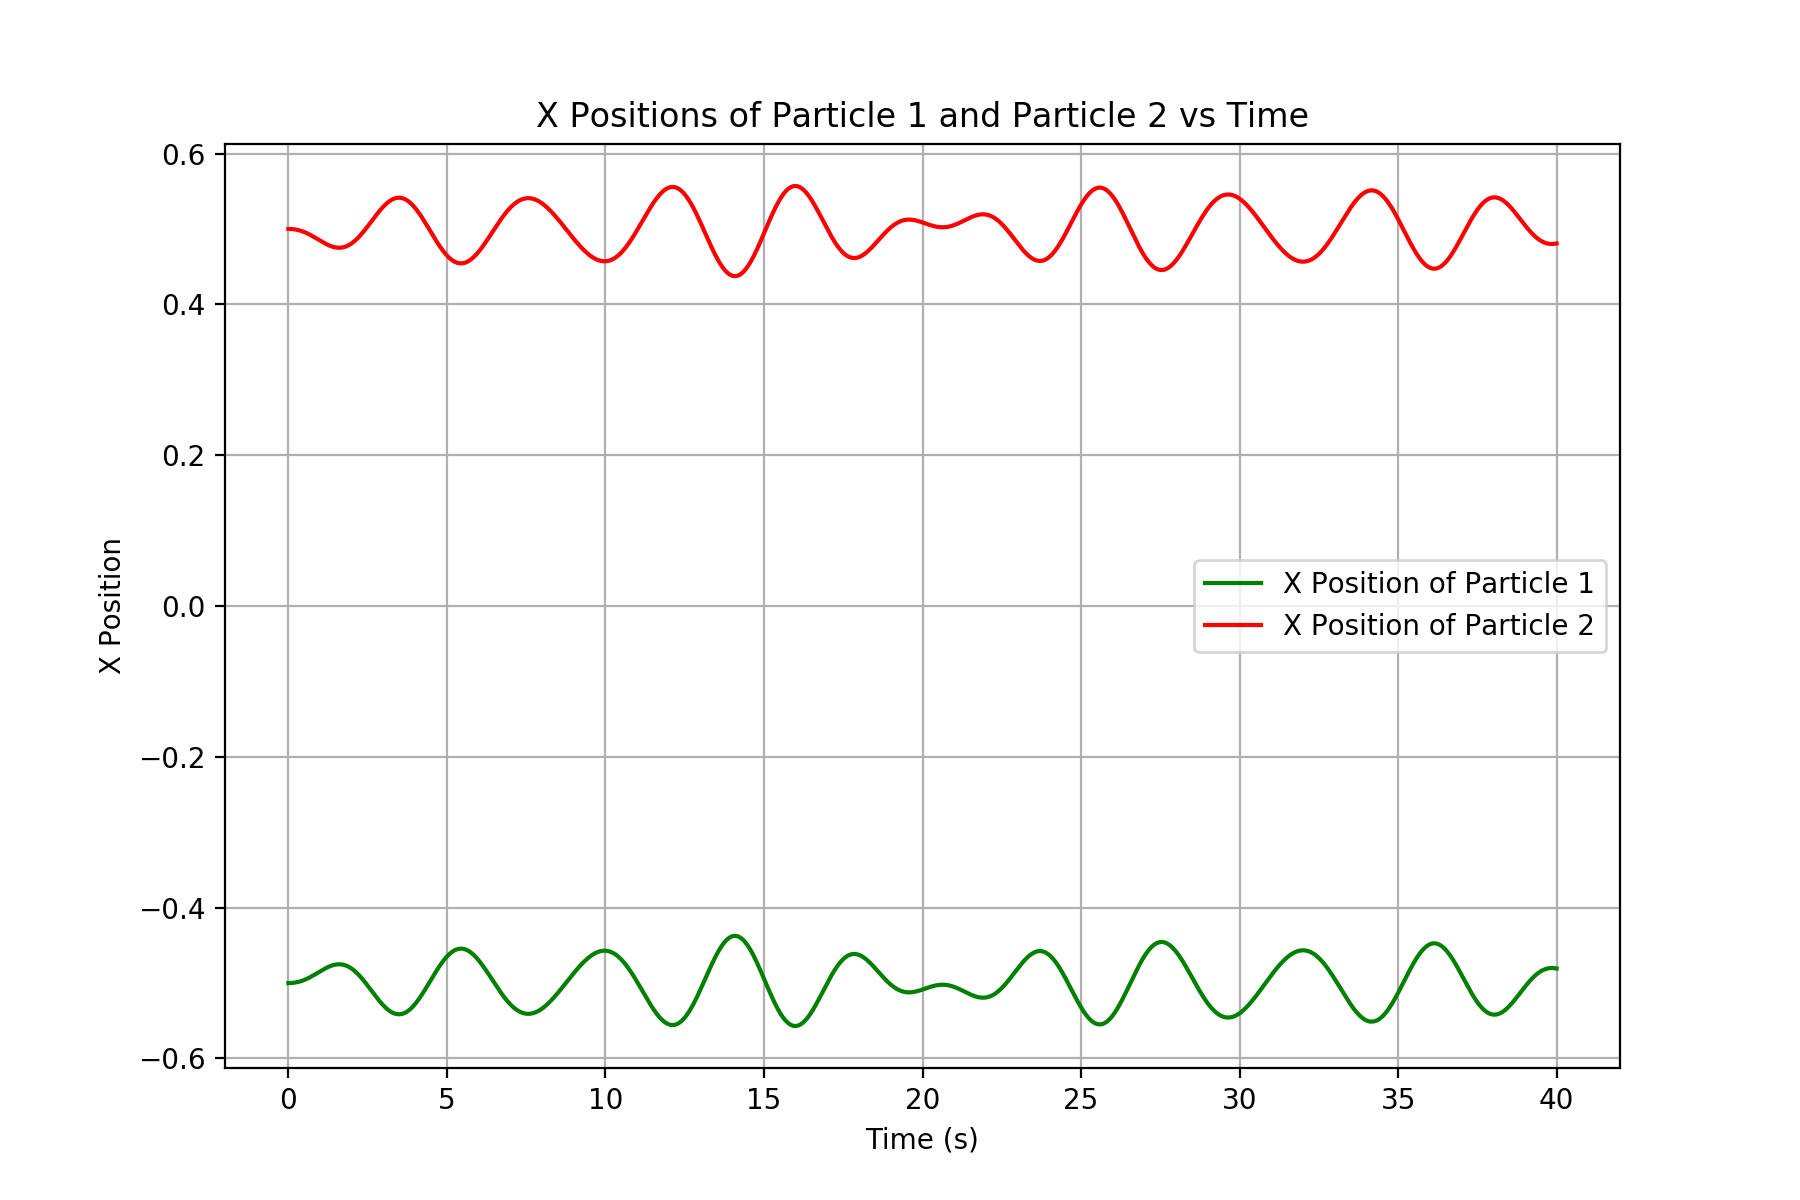

In [45]:
fig, (ax1) = plt.subplots(1, figsize=(9,6))

ax1.plot(timesteps, dipole_superPos.pos1[:, 0], 'g', label = "X Position of Particle 1")
ax1.plot(timesteps, dipole_superPos.pos2[:, 0], 'r', label = "X Position of Particle 2")
ax1.grid()


ax1.set_xlabel("Time (s)")
ax1.set_ylabel("X Position")


ax1.title.set_text("X Positions of Particle 1 and Particle 2 vs Time")
ax1.legend()

In [46]:
dipole_one = Dipole(timesteps = timesteps, distance =1,k = 1)
external_force_arr = E0*np.sin(omega_1*timesteps)
pos_one,pos_two = dipole_one.calc_trajectory()

dipole_two = Dipole(timesteps = timesteps, distance =1,k = 1)
external_force_arr = E1*np.sin(omega_1*timesteps+np.pi/3)
pos_one,pos_two = dipole_two.calc_trajectory()

fig, (ax1,ax2) = plt.subplots(2, figsize=(9,6))

ax1.plot(timesteps, dipole_one.pos1[:, 0], 'g', label = "X Position of Particle 1")
ax1.plot(timesteps, dipole_one.pos2[:, 0], 'r', label = "X Position of Particle 2")
ax1.grid()
ax1.legend()
ax1.title.set_text("X Positions of Particle 1 and Particle 2 vs Time")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("X Position")

ax2.plot(timesteps, dipole_two.pos1[:, 0], 'g', label = "X Position of Particle 1")
ax2.plot(timesteps, dipole_two.pos2[:, 0], 'r', label = "X Position of Particle 2")
ax2.grid()
ax2.legend()
ax2.title.set_text("X Positions of Particle 1 and Particle 2 vs Time")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("X Position")

fig.subplots_adjust(hspace=.35)

NameError: name 'E1' is not defined

<IPython.core.display.Javascript object>


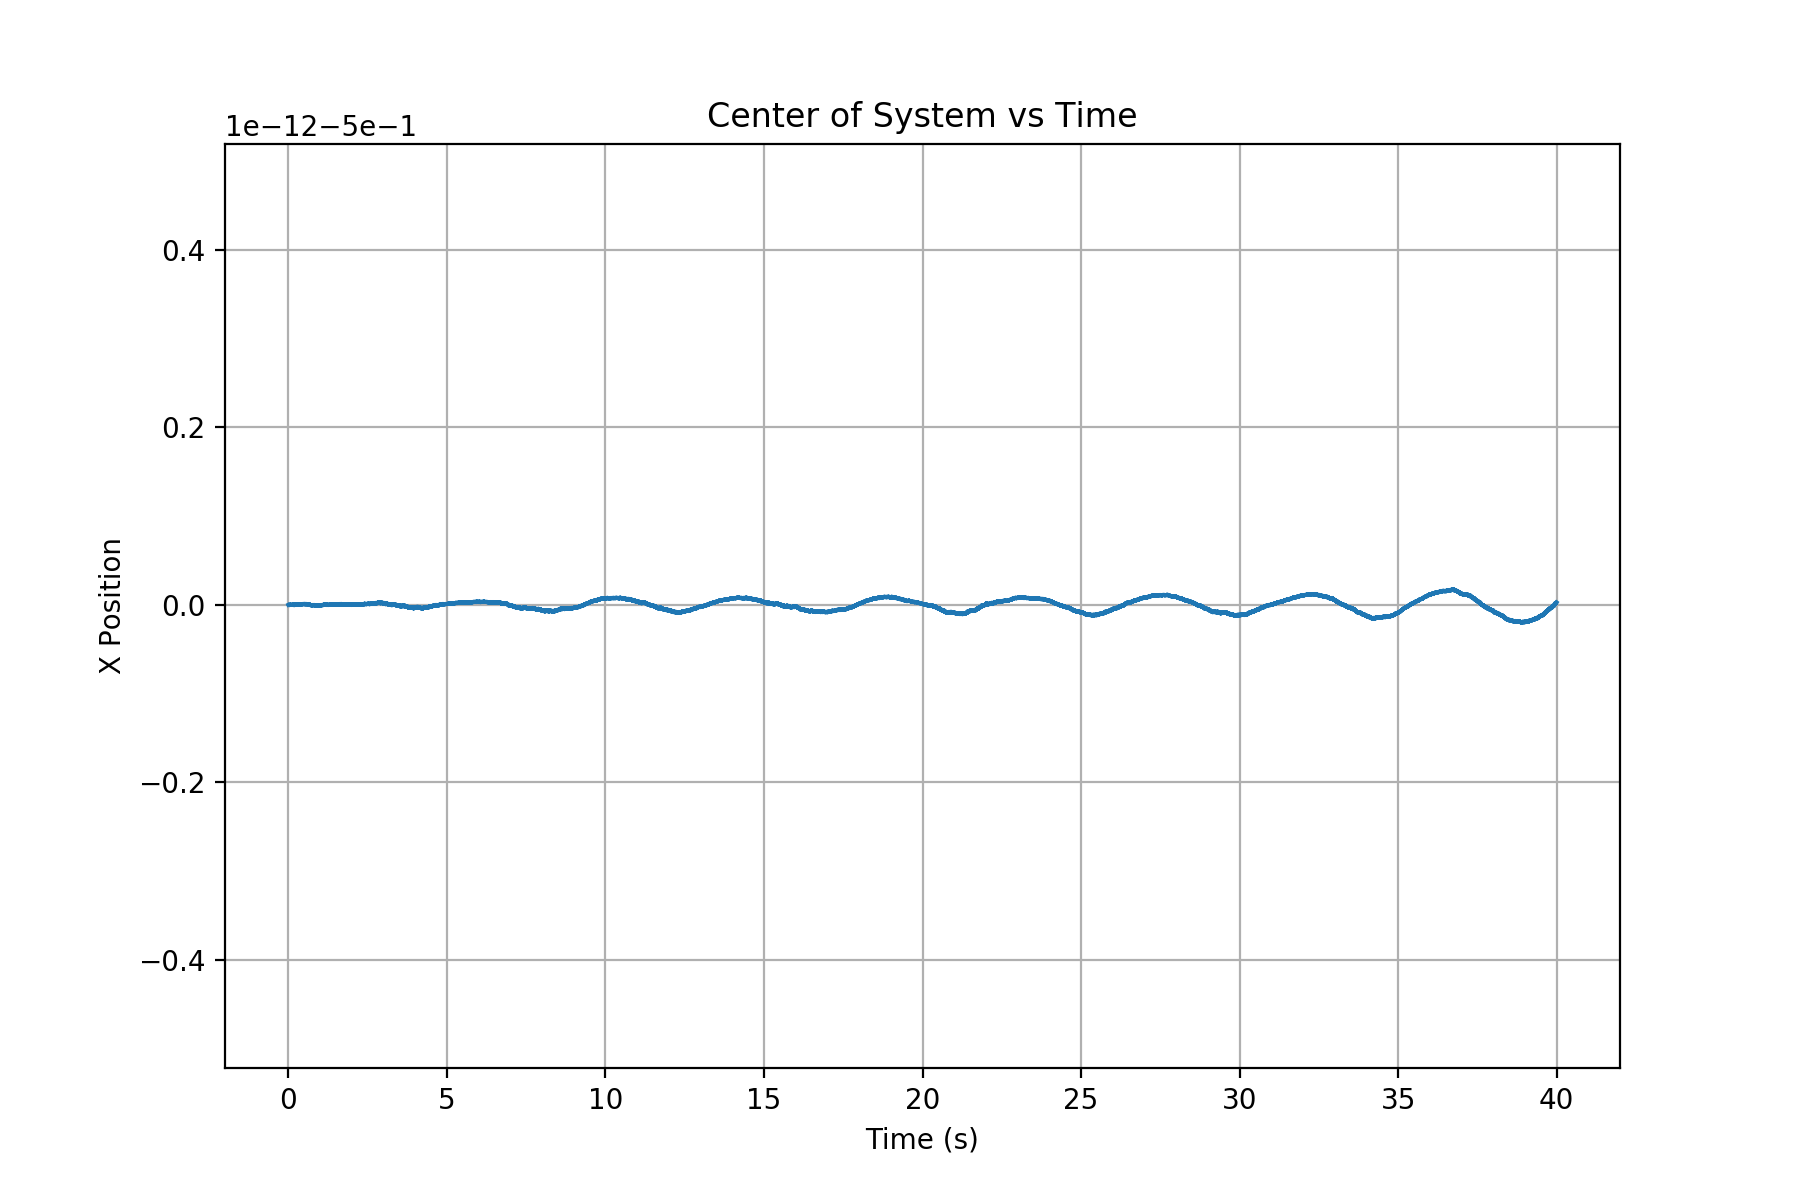

Text(0, 0.5, 'X Position')

In [28]:
fig, (ax1) = plt.subplots(1, figsize=(9,6))

difference = dipole_one.pos1 + dipole_two.pos1 -dipole_superPos.pos1 

ax1.plot(timesteps, difference[:,0])
ax1.grid()

ax1.title.set_text("Center of System vs Time")

ax1.set_xlabel("Time (s)")
ax1.set_ylabel("X Position")
#comfirms superposition